In [2]:
import numpy as np
import re
from collections import defaultdict
from collections import Counter
import pandas as pd

In probability theory and statistics, Bayes’ theorem describes the probability of an event, based on prior knowledge of conditions that might be related to the event.  
![image.png](attachment:image.png "Bayes Theorem")  
$$Prior Probablity(P\, of class A) = \frac{no. \,of\, samples\, of\, class\, A}{total\, number\, of\, samples}$$

$$Likelihood\,of\,feature\,x\,in\,class\,A = \frac{no. \,of\,occurance\,of\, feature\,x\,in\, class\, A}{total\, number\, of\, samples\,of\,class\,A}$$

$$Predictor\,Probablity (of\, feature\, x) = \frac{no. \,of\,occurance\,of\, feature\,x}{total\, number\, of\, samples}$$

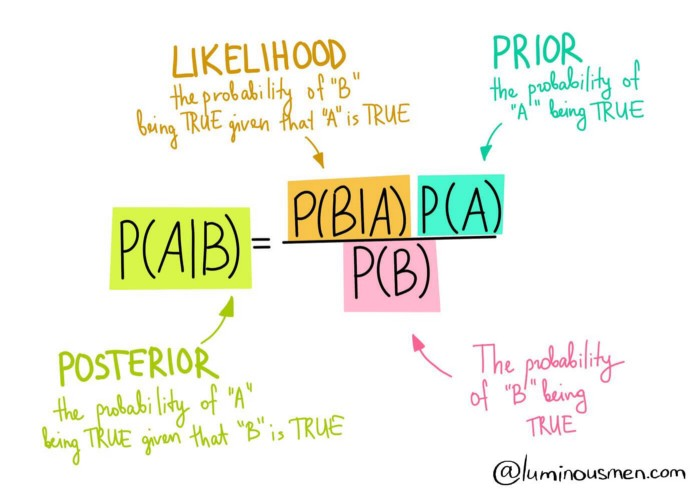

In [118]:
class NaiveBayes:
    def __init__(self,alpha=1):
        #self.classes = unique_classes #no of unique classes in train set
        self.likelihoods = {}
        self.class_priors = {}
        self.pred_priors = {}
        self.features = Counter()
        self.alpha = 1 #no of additional word count to prevent zero probablity for unknown word
    
    def preProcess(self,string):
        '''Clean the input sentence
        - removes non alphabets
        - remove multiple spaces,new lines and tabs
        - convert everything to lower case
        '''
        clutter=['is','the','are','am','and','you','for','at','on','your','to','as','in',
                 'not','but','ok','from','not','so','no','did']
        string = string.lower()
        for st in clutter:
            if ' '+st+' ' in string:string=string.replace(st,' ')
        string = re.sub('(\$\d+\.?\d*)','moneyamt',string)
        string=re.sub("(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)",' ',string)
        cleaned_str=re.sub('[^a-z\s]+',' ',string) #every non alphabets are replaced by space
        cleaned_str=re.sub('(\s[a-z]\s)',' ',cleaned_str)
        cleaned_str=re.sub('(\s+)',' ',cleaned_str) #multiple spaces are replaced by single space
        return cleaned_str.lower()
    
    def Bow(self, sample, cat):
        '''Create Bag of Words to Store Count of words of each unique class separetly'''
        for word in self.preProcess(sample).split():
            self.bow_dicts[cat][word]+=1
            
    def calc_priorP(self,y):
        '''Calculate prior probablity for each unique class'''
        for outcome in np.unique(y):
            outcome_count = sum(y == outcome)
            self.class_priors[outcome] = outcome_count/y.size
    
    def calc_Likelihood(self,features,y):
        '''calculate likelihood of each word(feature) for all unique classes'''
        for feature in features:
            self.likelihoods[feature] = {}
            for outcome in np.unique(y):
                outcome_count = sum(y == outcome)
                cat = np.where(self.labels==outcome)[0][0]
                #print(outcome, feature)
                self.likelihoods[feature][outcome] =  (self.bow_dicts[cat][feature]+self.alpha)/(outcome_count+len(self.bow_dicts[cat])*self.alpha)
    
    def calc_preditor_prior(self, features,y):
        '''calculate predictor probablity if each uniques feature'''
        for feature,count in features.items():
            self.pred_priors[feature] = count/y.size
    
    def predict(self, example):
        '''predict result using trained model'''
        example = self.preProcess(example)
        tokens = np.array(example.split())
        probs_outcome = {}
        for outcome in range(self.labels.size):
            #probs_outcome = {}
            prior = self.class_priors[self.labels[outcome]]
            likelihood = 1
            evidence = 1
            for word in tokens:
                if word in self.likelihoods: 
                    likelihood *= self.likelihoods[word][self.labels[outcome]]
                    evidence *= self.pred_priors[word]
                else:
                    #print(outcome)
                    outcome_count = np.sum(list(self.bow_dicts[outcome].values()))
                    likelihood*=self.alpha/(outcome_count+len(self.bow_dicts[outcome])*self.alpha+self.alpha)

            posterior = (likelihood * prior) / (evidence)
            probs_outcome[outcome] = posterior
        #print(probs_outcome.values())
        result = np.argmax(np.array(list(probs_outcome.values())))
        return self.labels[result]
    
    def train(self,X,Y):
        '''Train the model
            Calls methods to calculate required probablities and likelihood
        '''
        print("Training...")
        self.labels = np.unique(Y)
        self.bow_dicts = np.array([defaultdict(lambda:0) for index in range(self.labels.size)])
        for x,y in zip(X,Y):
            cat = np.where(self.labels==y)[0][0]
            self.Bow(x,cat)
        features = Counter()
        for f in [Counter(bow_dict) for bow_dict in self.bow_dicts]:
            features+=f
        self.calc_priorP(Y)
        print("1/3 completed")
        self.calc_Likelihood(features,Y)
        print("2/3 complted")
        self.calc_preditor_prior(features,Y)
        print("3/3 completed")
        print('Training Completed')
        
    def accuracy(self,x_test,y_test):
        result = np.array([])
        for x,y in zip(x_test,y_test):
            #print('Working')
            result = np.append(result,(self.predict(x))==y)
        #print(result)
        return (np.sum(result)/result.size)*100

## Test Algorithm 
**Testing on sample dataset**

In [119]:
nb = NaiveBayes()

In [120]:
spam = [
        'million dollar offer',
        'secret offer today',
        'secret is secret'
    ]
    
not_spam = [
        'low price for valued customer',
        'play secret sports today',
        'sports is healthy',
        'low price pizza'
    ]
test = np.array([
    'million dollar pizza',
    'healthy food',
    'secret sports play'
])
y_test =np.array(['Spam','Not Spam','Spam'])
X = spam + not_spam
Y = np.array(["Spam","Spam","Spam","Not Spam","Not Spam","Not Spam","Not Spam"])

In [121]:
nb.train(X,Y)

Training...
1/3 completed
2/3 complted
3/3 completed
Training Completed


In [122]:
nb.predict('healthy customer')

'Not Spam'

In [123]:
nb.accuracy(test,y_test)

66.66666666666666

In [124]:
nb.predict('Ten million~3#1')

'Spam'

## Working With Real Dataset
  **Covid Tweets Classifier**
  
  Dataset Source : https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

In [125]:
df_train = pd.read_csv('Corona_NLP_train.csv') 
df_train.drop(['UserName','ScreenName','Location','TweetAt'],axis=1,inplace=True)
df_train.loc[df_train['Sentiment']=='Extremely Negative','Sentiment'] = 'Negative'
df_train.loc[df_train['Sentiment']=='Extremely Positive','Sentiment'] = 'Positive'
df_train = df_train[:7000]
df_train.sample(10)

,OriginalTweet,Sentiment
637,Is #coronavirus making @realDonaldTrump look b...,Positive
6752,This is just making so BLOODY ANGRY at the mom...,Negative
99,@joncoopertweets I took these pictures today a...,Negative
2536,Nice one @SkyNews lets not panic but show ppl ...,Negative
2818,"Also, stock up on things like this...don't hoa...",Positive
2895,Unbelievable! Major retail industry's supply a...,Negative
5735,As world prepares for due to has a lot to teac...,Negative
5653,Just a thought - everyone should dabble in a b...,Negative
1741,It's quite true. I walked to grocery store yes...,Positive
5048,Data from @Conferenceboard shows that for ever...,Negative


In [126]:
naive = NaiveBayes()
naive.train(df_train['OriginalTweet'],df_train['Sentiment'])

Training...
1/3 completed
2/3 complted
3/3 completed
Training Completed


In [127]:
df_test = pd.read_csv('Corona_NLP_test.csv') 
df_test.drop(['UserName','ScreenName','Location','TweetAt'],axis=1,inplace=True)
df_test.loc[df_test['Sentiment']=='Extremely Negative','Sentiment'] = 'Negative'
df_test.loc[df_test['Sentiment']=='Extremely Positive','Sentiment'] = 'Positive'
df_test.sample(10)

,OriginalTweet,Sentiment
977,"Co, ro, and na coming together to lower gas pr...",Negative
2778,Im starting to wonder why did I not stock pil...,Positive
3454,Real talk though. Am I the only one spending h...,Neutral
2654,For those of us whove been avoiding people lo...,Negative
2939,i kinda want to go to walmart or some grocery ...,Negative
2225,Fucking people on the internet trying to make ...,Negative
635,We have to take care of each other. If you are...,Positive
2162,? URGENT ?\r\r\n\r\r\nW/ the hysteria re #Covi...,Positive
2501,Anyone else doing some online shopping right n...,Positive
3003,Have to say California is very controlled with...,Positive


In [128]:
df_test.shape

(3798, 2)

In [129]:
naive.predict(df_test['OriginalTweet'].iloc[1])

'Positive'

In [130]:
naive.accuracy(df_test['OriginalTweet'],df_test['Sentiment'])

62.03264876250658

In [131]:
naive.accuracy(df_test['OriginalTweet'],df_test['Sentiment'])

62.03264876250658

In [117]:
naive.preProcess(df_test['OriginalTweet'].iloc[1])

'when couldn find hand sanitizer fred meyer turned amazon moneyamt pack of purell check out how coronavirus concerns driving up prices '

In [30]:
df_test['OriginalTweet'].iloc[2]

'Find out how you can protect yourself and loved ones from #coronavirus. ?'

In [63]:
df_test['Sentiment'].iloc[1]

'Positive'